# Variogram, Kriging, Random Conditioned Example
In this Colab notebook:

Goals 
- quantify how a property (here temperature) changes in space (variograms)
- use this to make interpolation maps (Kriging) that account for this spatial correlation 

We will repeat these steps twice
  1) calculate experimental variogram (from the data)
  2) fit a modeled (continuous) variogram for all distances
 
- Variogram exploration & calculation
    - ~~Which directions have highest spatial correlation?~~  <font color=green> move to end
    - <font color=green> just do range deo
    - <font color=pink> look at INGENIOUS Gabbs data
     /Users/whitneytrainor-guitton/Dropbox/Proposals/PF2_Reno/data/INGENIOUS_project_data/Local_site_selection_Task2/Temperatures_2meter <font color=black>
    gabbs_temp_well = gpd.read_file('ExportedFiles/gabbs_temp_well.shp')
- Kriging spatial interpolation
- Quasi-stochastic modeling
- 3D Kriging 
- 3D visualization with PyVista

Through all of this you'll be introduced to manipulating data and plotting with Python & Colab.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
%%html
<iframe src="https://drive.google.com/file/d/1OQSOpLykiMW_t6olD-pP1lfiNIPpxckz/preview" width="640" height="480" allow="autoplay"></iframe>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import pandas as pd

In [7]:
import os
import subprocess

try:
    import leafmap
except ImportError:
    print('Installing leafmap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'leafmap'])

import leafmap.foliumap as leafmap 
import folium

### Let's get some data. 
This command (notice the `!` is a system command so like you are in shell window) will put the file in your current colab directory (*not* your personal google drive)

`wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O FILENAME4Saving`

In [8]:
# https://drive.google.com/file/d/1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc/view?usp=sharing
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc' -O WGC_temp.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV'  -O GSV_2mtemp.csv

--2022-03-13 11:11:12--  https://docs.google.com/uc?export=download&id=1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV
Resolving docs.google.com (docs.google.com)... 173.194.215.101, 173.194.215.100, 173.194.215.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e7a4htb29dnk3i9ik4r5c53u34s6obj2/1647169800000/03887978596655340594/*/1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV?e=download [following]
--2022-03-13 11:11:12--  https://doc-04-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e7a4htb29dnk3i9ik4r5c53u34s6obj2/1647169800000/03887978596655340594/*/1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV?e=download
Resolving doc-04-0o-docs.googleusercontent.com (doc-04-0o-docs.googleusercontent.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to doc-04-0o-docs.googleusercontent.com (doc-04-0o-docs

You can see what's in the temporary Colab directory. Also see if you click the folder icon on the far left of your screen.

In [9]:
!ls -ltr 

total 8
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data
-rw-r--r-- 1 root root 1167 Mar 13 11:11 GSV_2mtemp.csv


Now we use some pandas to read the csv file into a DataFrame

In [10]:
if IN_COLAB:
#     temp_df = pd.read_csv('/content/WGC_temp.csv')
    temp_df = pd.read_csv('GSV_2mtemp.csv')
else:
# !ls ../../Colab\ Notebooks/GRC_StudentsWorkshop/Public
#     temp_df = pd.read_csv('../../Colab Notebooks/GRC_StudentsWorkshop/Public/WGC_data.csv')
    temp_df = pd.read_csv('GSV_xy2mCorr.csv')


In [11]:
temp_df

,Unnamed: 0,index,x_easting,y_northing,2mCorr,latitude,longitude
0,0,0,329261.0,4427358.0,9.5,39.979153,-118.999550
1,1,1,329206.0,4426901.0,8.4,39.975026,-119.000074
2,2,2,330362.0,4427475.0,9.7,39.980428,-118.986694
3,3,3,331695.0,4428308.0,8.2,39.988195,-118.971307
4,4,4,331023.0,4429089.0,9.0,39.995093,-118.979377
5,5,5,330109.0,4430126.0,9.8,40.004247,-118.990348
6,6,6,329632.0,4431139.0,9.0,40.013273,-118.996199
7,7,7,328876.0,4430727.0,9.5,40.009410,-119.004943
8,8,8,328724.0,4429683.0,10.0,39.999979,-119.006448
9,9,9,329652.0,4428857.0,9.4,39.992729,-118.995366


In [12]:
temp_df = temp_df.drop(columns='Unnamed: 0') # get rid of junk column
temp_df.head()

,index,x_easting,y_northing,2mCorr,latitude,longitude
0,0,329261.0,4427358.0,9.5,39.979153,-118.999550
1,1,329206.0,4426901.0,8.4,39.975026,-119.000074
2,2,330362.0,4427475.0,9.7,39.980428,-118.986694
3,3,331695.0,4428308.0,8.2,39.988195,-118.971307
4,4,331023.0,4429089.0,9.0,39.995093,-118.979377


Let's check the summary statistics of this little dataset

In [13]:
temp_df.describe()

,index,x_easting,y_northing,2mCorr,latitude,longitude
count,17.000000,17.000000,1.700000e+01,17.000000,17.000000,17.000000
mean,8.000000,329515.058824,4.429642e+06,9.052941,39.999766,-118.997176
std,5.049752,871.281131,2.179169e+03,0.676496,0.019578,0.010362
min,0.000000,328478.000000,4.426901e+06,7.600000,39.975026,-119.010178
25%,4.000000,328876.000000,4.427475e+06,8.500000,39.980428,-119.004943
50%,8.000000,329261.000000,4.429089e+06,9.200000,39.995093,-118.999550
75%,12.000000,329727.000000,4.431139e+06,9.500000,40.013273,-118.995366
max,16.000000,331695.000000,4.433631e+06,10.000000,40.035628,-118.971307


Plot what it looks like in space

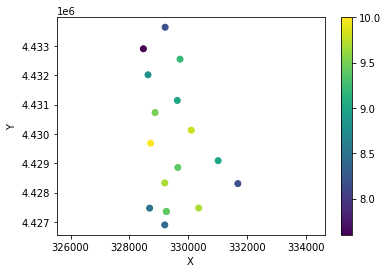

In [14]:
plt.scatter(temp_df['x_easting'],temp_df['y_northing'],c=temp_df['2mCorr']) #,vmin=7, vmax=10)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

In [15]:
m = leafmap.Map(center=(40,-118), zoom=8)
m.add_heatmap(
    temp_df,
    longitude="longitude", latitude="latitude",
    value='2mCorr',
    name="Heat map",
    radius=10,
)
m

# Install packages for plotting and geostatistic tools

In [17]:
!pip install gstools

     |████████████████████████████████| 1.3 MB 3.2 MB/s 
     |████████████████████████████████| 167 kB 46.1 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 224 kB 57.0 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 


In [18]:
import gstools as gs

[PyVista](https://docs.pyvista.org/getting-started/installation.html) has awesome plotting tools. [GSTools](https://pypi.org/project/gstools/) is the library we will use to demonstrate some geostatistical concepts.



# Experimental Variogram calculation
First let's establish a variable of *where* the data is (position: `pos`) and the data value (value: `val`) which will be used for *conditioning* the geostatistical interpolation.

In [19]:
temp_cond_pos = [[temp_df.x_easting], [temp_df.y_northing]]
temp_cond_val = temp_df['2mCorr']
print(np.shape(temp_cond_val))
print(np.shape(temp_cond_pos))
temp_cond_pos

(17,)
(2, 1, 17)


[[0     329261.0
  1     329206.0
  2     330362.0
  3     331695.0
  4     331023.0
  5     330109.0
  6     329632.0
  7     328876.0
  8     328724.0
  9     329652.0
  10    329207.0
  11    328690.0
  12    328635.0
  13    328478.0
  14    329727.0
  15    329218.0
  16    329261.0
  Name: x_easting, dtype: float64], [0     4427358.0
  1     4426901.0
  2     4427475.0
  3     4428308.0
  4     4429089.0
  5     4430126.0
  6     4431139.0
  7     4430727.0
  8     4429683.0
  9     4428857.0
  10    4428330.0
  11    4427472.0
  12    4432012.0
  13    4432898.0
  14    4432544.0
  15    4433631.0
  16    4427358.0
  Name: y_northing, dtype: float64]]

This function calculates the difference of pairs of data at different distances. 

`gs.vario_estimate((temp_cond_pos), temp_cond_val, return_counts=True)`

which is this calculation
 <font size="5">   
 $\gamma(h) = \frac{1}{2N(h)}\Sigma_{i=1}^{N(h)} [z(u] - z(u+h)]^2$ 
    </font>

Text(0.5, 1.0, 'Experimental variogram $\\gamma$')

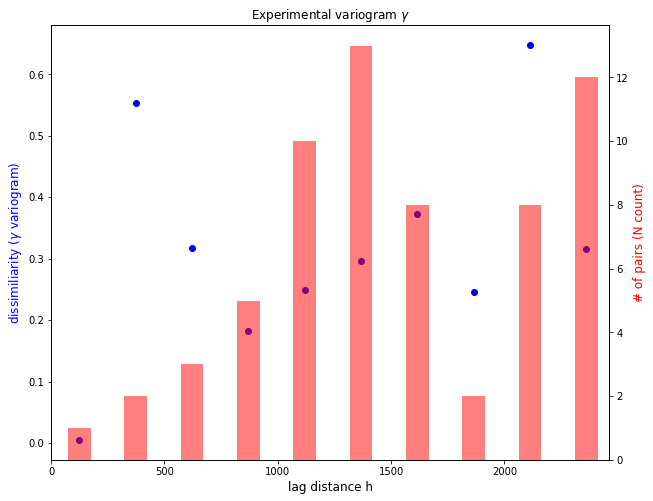

In [20]:
bin_center, gamma, omni_counts = gs.vario_estimate((temp_cond_pos), temp_cond_val, return_counts=True)

fig, axes = plt.subplots(figsize=(10,8))
axes2 = axes.twinx()
# Eperimental variogram (from the data)
axes.scatter(bin_center, gamma,c='b', label='omni')
axes2.bar(bin_center,omni_counts, width=100, color='red',alpha=0.5)

#axes.legend()
axes.set_xlabel('lag distance h', fontsize=12)
axes.set_ylabel('dissimiliarity ($\gamma$ variogram)', fontsize=12, color='blue')
axes2.set_ylabel('# of pairs (N count)', fontsize=12, color='red')
axes.set_xlim([0, np.max(bin_center)+100])
# axes.set_ylim([0, 1])
gammastring='$\gamma$'
titletxt = 'Experimental variogram '+gammastring

axes.set_title(titletxt)

These are the $h$'s

In [21]:
bin_center

array([ 124.32259672,  372.96779016,  621.61298361,  870.25817705,
       1118.90337049, 1367.54856394, 1616.19375738, 1864.83895082,
       2113.48414426, 2362.12933771])

## Which variogram model type is best to use?
This cell is looping through the different types of variograms which all have a bit of different behavior at different lag distances ($h$).

$a$ is the effective range : the distance at which there's no longer anycorrelation in that direction.

For example:
- Exponential: $Exp(h) = 1 -exp(-3h/a)$
- Spherical: $Sph(h) = 1.5(h/a) - 0.5(h/a)^3$ 
- Gaussian: $Gaus(h) = 1 -exp(-3(h/a)^2)$

Exponential(dim=2, var=0.336, len_scale=1.89e+02, nugget=0.01)
Spherical(dim=2, var=0.335, len_scale=4.21e+02, nugget=0.01)
Gaussian(dim=2, var=0.339, len_scale=1.84e+02, nugget=0.01)


Text(0, 0.5, 'Dissimiliarity (variogram value)')

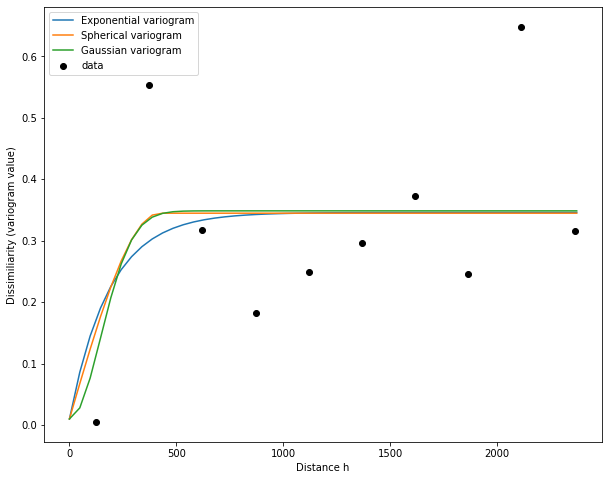

In [22]:
varmodeltypes = {
  "Exponential": gs.Exponential,
  "Spherical": gs.Spherical,
  "Gaussian": gs.Gaussian
}

scores = {}

plt.figure(figsize=(10,8))
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram, with the same nugget
for model in varmodeltypes:
    fit_model = varmodeltypes[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True,nugget=0.01)
    fit_model.plot(x_max=np.max(bin_center)+10, ax=ax)
    scores[model] = r2
    print(fit_model)

ax.set_xlabel('Distance h')
ax.set_ylabel('Dissimiliarity (variogram value)')

Which one of those fit the data best?

R^2 score

In [23]:
import operator
sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_scores)

[('Gaussian', 0.3125153210886903), ('Spherical', 0.28465567630664546), ('Exponential', 0.20817358239522143)]


# Choose variogram model type, then fit the experimental data for each direction
The `Gaussian` variogram has the best `r^2` score, but feel free to try others.

In [24]:
bin_center, gamma, omni_counts = gs.vario_estimate((temp_cond_pos), temp_cond_val, return_counts=True)

vario_model = gs.Gaussian(dim=2) #Gaussian(dim=2)

vario_model.fit_variogram(bin_center, gamma, nugget=0.02)

vario_model

Gaussian(dim=2, var=0.328, len_scale=1.85e+02, nugget=0.02)

Now let's plot the experimental variogram (raw from the data, scatter plot) and the modeled variogram.

Text(0.5, 1.0, 'Gaussian(dim=2, var=0.328, len_scale=1.85e+02, nugget=0.02) & Experimental variogram')

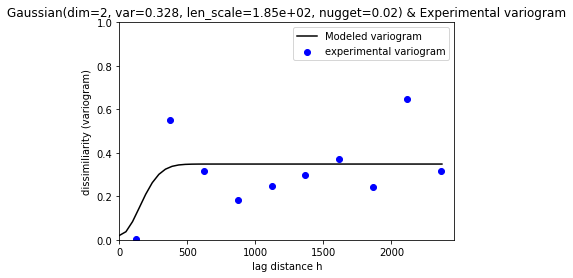

In [25]:
fig, axes = plt.subplots()#figsize=(10,8))
# Modeled (fitted) variogram : continuous
vario_model.plot(c='k', label='Modeled variogram',ax=axes,x_max=np.max(bin_center)+10)
# Eperimental variogram (from the data)
axes.scatter(bin_center, gamma,c='b', label='experimental variogram')

axes.legend()
axes.set_xlabel('lag distance h')
axes.set_ylabel('dissimiliarity (variogram)')
axes.set_xlim([0, np.max(bin_center)+100])
axes.set_ylim([0, 1])
titletxt = str(vario_model)+' & Experimental variogram'
axes.set_title(titletxt)

# Plot with different inferred ranges of variogram of spatial continuity

[This Colab demo](https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=_00aYIMEXVGS) will explain how the plotting widgets (tabs) work.

In [26]:
if IN_COLAB:
    from google.colab import widgets

# 2D Kriging: spatial interpolation with the $\gamma$ 

First, define the regular grid on which the interpolation will be done. Check how big it is.

In [27]:
gridx = np.arange(np.min(temp_df.x_easting)-500, np.max(temp_df.x_easting)+500,10)
gridy = np.arange(np.min(temp_df.y_northing)-500, np.max(temp_df.y_northing)+500,10)
np.shape(gridx), np.shape(gridy)

((422,), (773,))

In [28]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import mpl_toolkits.axisartist.floating_axes as floating_axes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.299, len_scale=2e+02, nugget=0.05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

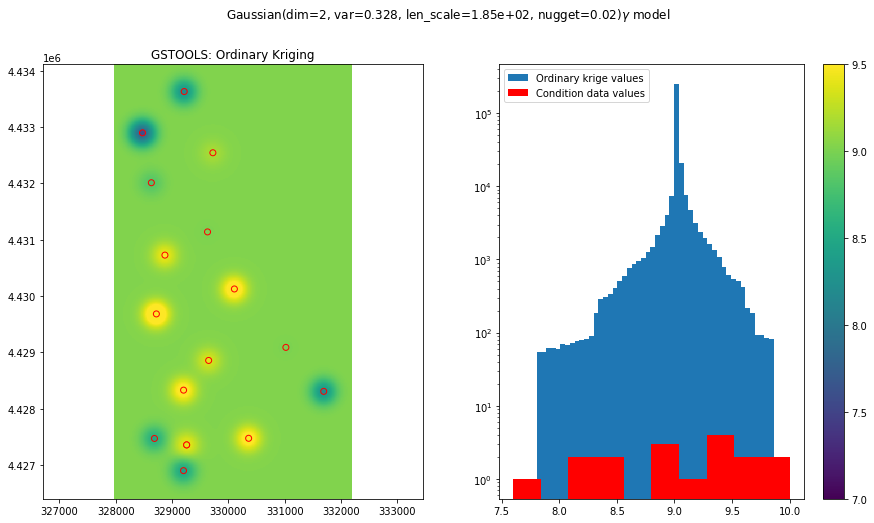

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.309, len_scale=5e+02, nugget=0.05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

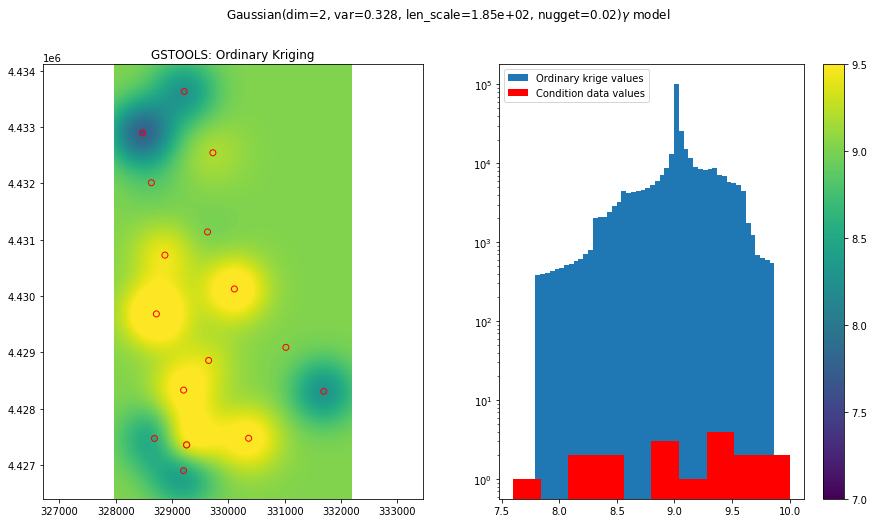

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.327, len_scale=7e+02, nugget=0.05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

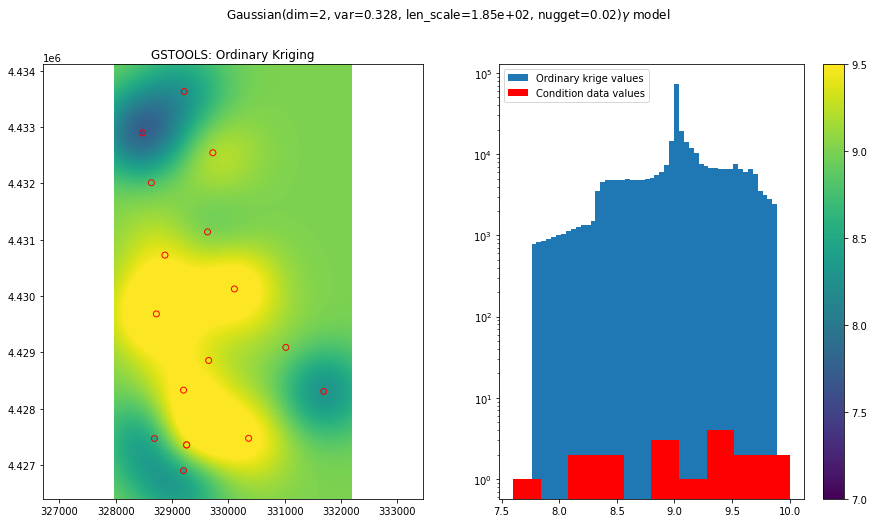

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.372, len_scale=1e+03, nugget=0.05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

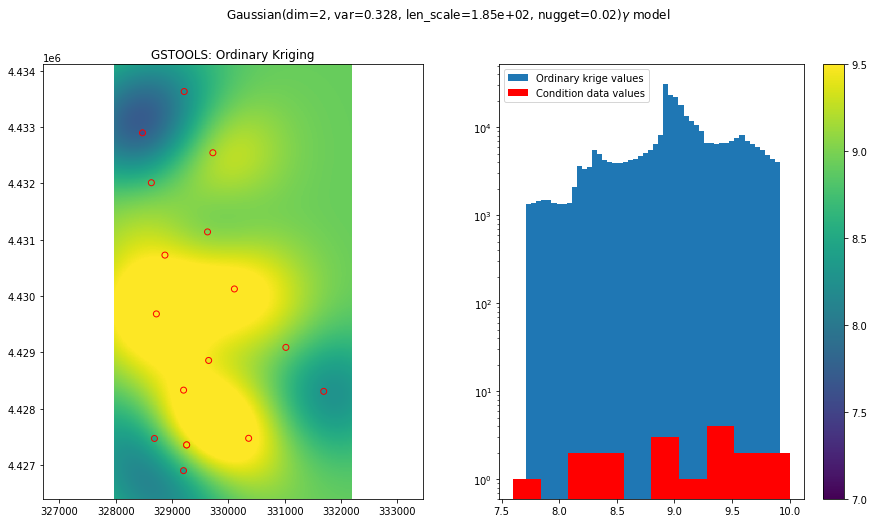

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.413, len_scale=1.2e+03, nugget=0.05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

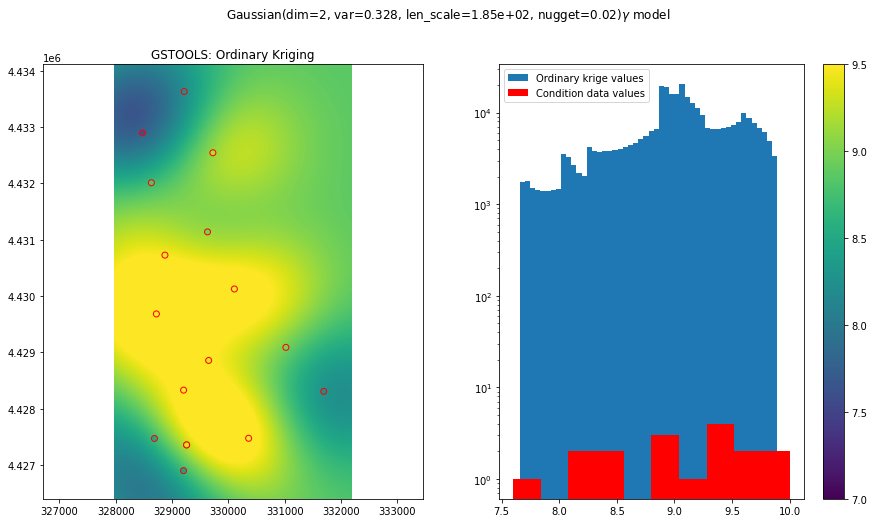

<IPython.core.display.Javascript object>

In [29]:
diff_ranges = [200,500, 700, 1000, 1200] 

if IN_COLAB:
    tb3 = widgets.TabBar(['2d Kriging with this range  '+str(diff_ranges[i]) for i in range(np.shape(diff_ranges)[0])])
else:
    ## local conda
    fig, myax = plt.subplots(figsize=[10,15],ncols = 2, nrows = np.shape(diff_ranges)[0])
# 

for i in range(np.shape(diff_ranges)[0]):
    
    gauss2d_model= gs.Gaussian(dim=2)
    gauss2d_model.fit_variogram(bin_center, gamma, len_scale=diff_ranges[i], nugget=0.05)

    print('made with this variogram model: ',gauss2d_model)
    krigeOK = gs.krige.Ordinary(gauss2d_model, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
    krigeOK.structured((gridx, gridy))

    my_vmin = 7 # 10
    my_vmax = 9.5 #90

    ## Only select the first 2 tabs, and render others in the background.
    if IN_COLAB:

        ## Only select the first 2 tabs, and render others in the background.
        with tb3.output_to(i, select=(i < 2)):

          f, myax = plt.subplots(figsize=[15, 8], nrows=1, ncols=2)
          myax = myax.flatten()
          # plot the result
          phandle =myax[0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[0].set_title('GSTOOLS: Ordinary Kriging')
          myax[0].axis('equal')
          cb = plt.colorbar(phandle)

          myax[1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[1].set_yscale('log')
          myax[1].legend()

          titletxt = str(vario_model)+'$\gamma$ model'
          plt.suptitle(titletxt)
    else:
          # plot the result
          phandle =myax[i,0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[i,0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[i,0].set_title('GSTOOLS: Ordinary Kriging')
          myax[i,0].axis('equal')
          divider = make_axes_locatable(myax[i,0])  
          cax = divider.append_axes("right", size="5%", pad=0.1)  
          cb=plt.colorbar(phandle, cax=cax)

          myax[i,1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[i,1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[i,1].set_yscale('log')
          myax[i,1].legend()

          titletxt = str(diff_ranges[i])+' range $\gamma$'
          myax[i,0].set_title(titletxt,fontsize=12)
          plt.tight_layout()

# Directional Variograms 

## Angles: Radian
Let's compute the variabilty in directions.

We need the directions in radians, not angles.

| Degree  | Radians  |
|:-:|:-:|
| 0  | 0  |
| 45  | 0.78539816  |
| 90  | 1.57079633  |
| 135  | 2.35619449  |
| 180  | 3.14159265  |

In [30]:
mydegrees = [0,45,90,135,180]
myrads=np.radians(mydegrees); myrads

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265])

In [31]:
bin_center, gamma_0 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=0) #cond_val, bins)
bin_center, gamma_45 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=0.78539816)
bin_center, gamma_90 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=1.57079633)
bin_center, gamma_135 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=2.35619449)
bin_center, gamma_180 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=3.14159265)

#?gs.vario_estimate
print('gamma_0',gamma_0)
print('gamma_90',gamma_90)
print('gamma_135',gamma_135)
print('gamma_180',gamma_180)

gamma_0 [0.005  0.     0.4525 0.     0.0325 0.46   0.72   0.     0.72   0.5   ]
gamma_90 [0.005      0.5525     0.         0.26166667 0.125      0.247
 0.06166667 0.245      1.14333333 0.2175    ]
gamma_135 [0.005      0.         0.         0.005      0.33       0.09625
 0.045      0.         0.4925     0.59333333]
gamma_180 [0.005  0.     0.4525 0.     0.0325 0.46   0.72   0.     0.72   0.5   ]


<font size=5> Now that we know from plot above, which direction has highest correlation. We can calculate the variogram for each of these angles.

<font size=5> Initiate the MODELED directional variograms:
</font>

In [32]:
vario_model_0 = gs.Gaussian(dim=2)
vario_model_90 =gs.Gaussian(dim=2)
vario_model_45 =gs.Gaussian(dim=2)
vario_model_135 =gs.Gaussian(dim=2)
vario_model_180 =gs.Gaussian(dim=2)

vario_model_0.fit_variogram(bin_center, gamma_0, nugget=0.05)
vario_model_90.fit_variogram(bin_center, gamma_90, nugget=0.05)
vario_model_45.fit_variogram(bin_center, gamma_45, nugget=0.05)
vario_model_135.fit_variogram(bin_center, gamma_135, nugget=0.05) 
vario_model_180.fit_variogram(bin_center, gamma_180, nugget=0.05) 

({'len_scale': 1505.0654815795785, 'nugget': 0.05, 'var': 0.5792504708432387},
 array([[3.09947328e-01, 7.45264004e+02],
        [7.45264004e+02, 1.97995146e+06]]))

Text(0.5, 1.0, 'Gaussian(dim=2, var=0.328, len_scale=1.85e+02, nugget=0.02) & Experimental variogram')

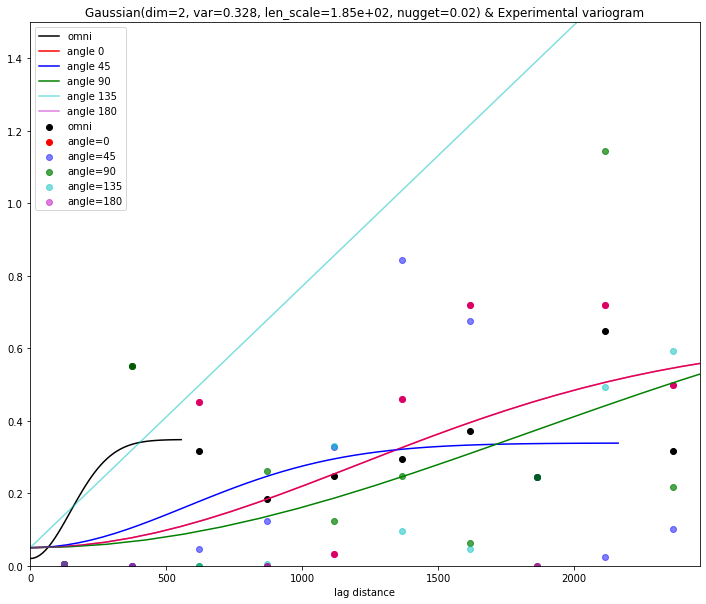

In [33]:
fig, axes = plt.subplots(figsize=(12,10))

vario_model.plot(c='k', label='omni',ax=axes)
vario_model_0.plot(c='r', label='angle 0',ax=axes)
vario_model_45.plot(c='b', label='angle 45',ax=axes)
vario_model_90.plot(c='g', label='angle 90',ax=axes)
vario_model_135.plot(c='c', label='angle 135',ax=axes,alpha=0.5)
vario_model_180.plot(c='m', label='angle 180',ax=axes,alpha=0.5)

axes.scatter(bin_center, gamma,c='k', label='omni')
axes.scatter(bin_center, gamma_0,c='r', label='angle=0')
axes.scatter(bin_center, gamma_45,c='b',label='angle=45',alpha=0.5)
axes.scatter(bin_center, gamma_90,c='g',label='angle=90',alpha=0.7)
axes.scatter(bin_center, gamma_135,c='c',label='angle=135',alpha=0.5)
axes.scatter(bin_center, gamma_180,c='m',label='angle=180',alpha=0.5)
axes.legend()
axes.set_xlabel('lag distance')
axes.set_xlim([0, np.max(bin_center)+100])
axes.set_ylim([0, 1.5])
titletxt = str(vario_model)+' & Experimental variogram'
axes.set_title(titletxt)

In [ ]:
all_fitted_1D = [vario_model_0, vario_model_45, vario_model_90, vario_model_135, vario_model_180]
all_fitted_1D 

In [ ]:
mydegrees

[0, 45, 90, 135, 180]

# Kriging with directional variograms

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.579, len_scale=1.51e+03, nugget=0.05)


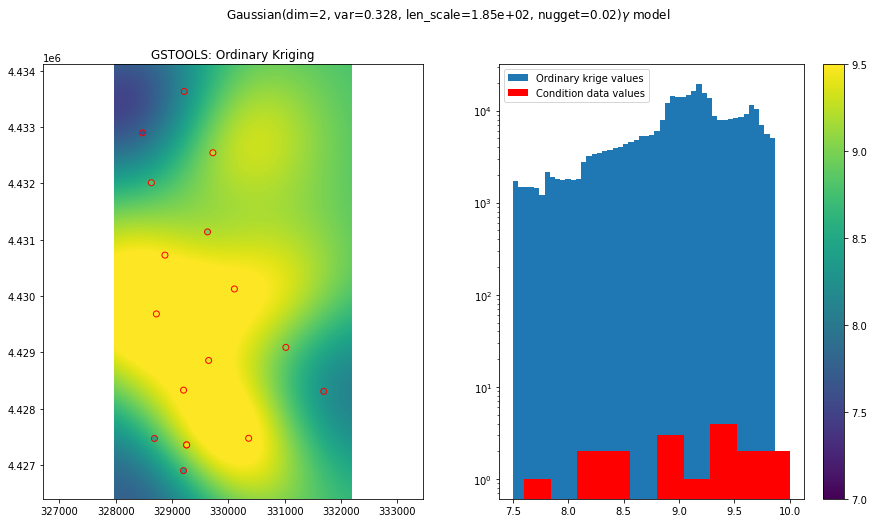

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.289, len_scale=7.21e+02, nugget=0.05)


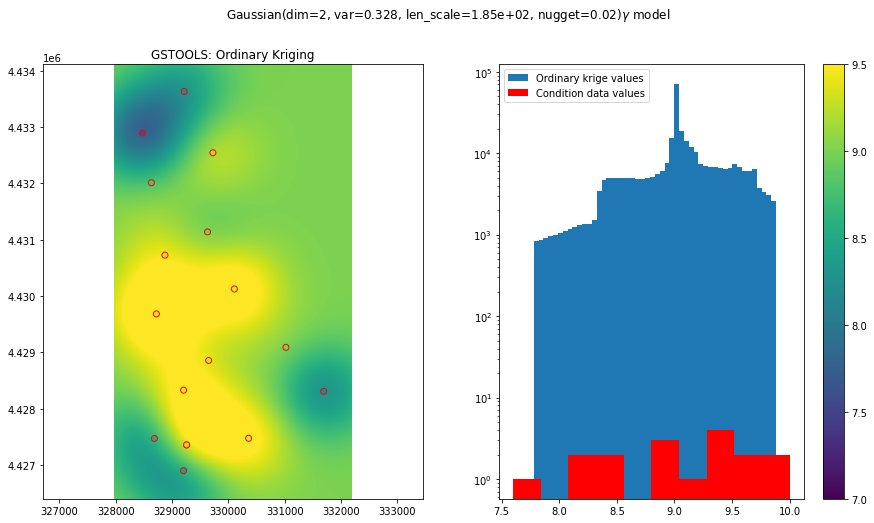

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.806, len_scale=2.3e+03, nugget=0.05)


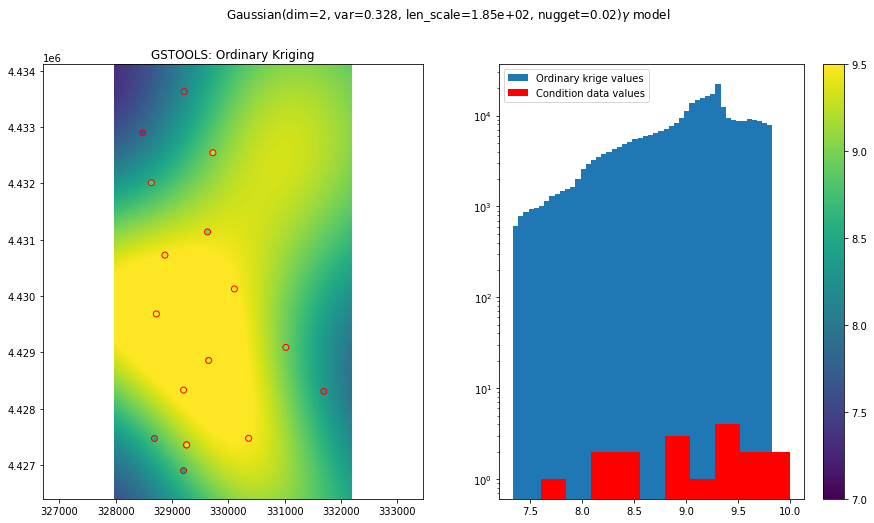

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=2.57e+03, len_scale=1.71e+05, nugget=0.05)


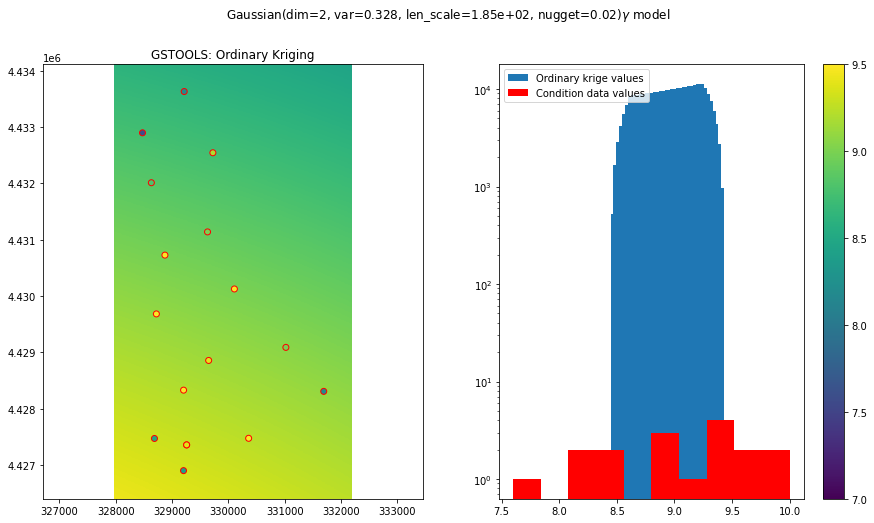

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.579, len_scale=1.51e+03, nugget=0.05)


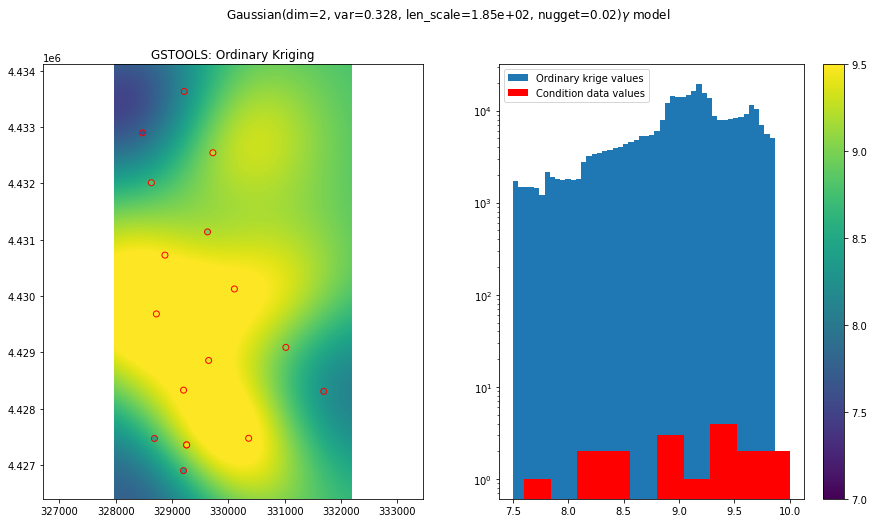

<IPython.core.display.Javascript object>

In [35]:
if IN_COLAB:
    tb2 = widgets.TabBar(['2d Kriging with this continuity  '+str(mydegrees[i]) for i in range(np.shape(mydegrees)[0])])
else:
    ## local conda
    fig, myax = plt.subplots(figsize=[10,15],ncols = 2, nrows = np.shape(mydegrees)[0])
#     myax = myax.flatten()

for i in range(np.shape(mydegrees)[0]):

    ## Only select the first 2 tabs, and render others in the background.
    if IN_COLAB:
        with tb2.output_to(i, select=(i < 2)):

          vario_model_Krige = all_fitted_1D[i]
        
          krigeOK = gs.krige.Ordinary(vario_model_Krige, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
          krigeOK.structured((gridx, gridy))

          print('made with this variogram model: ',vario_model_Krige)
          np.shape(krigeOK.field)
          my_vmin = 7 # 10
          my_vmax = 9.5 #90

          f, myax = plt.subplots(figsize=[15, 8], nrows=1, ncols=2)
          myax = myax.flatten()
          # plot the result
          phandle =myax[0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[0].set_title('GSTOOLS: Ordinary Kriging')
          myax[0].axis('equal')
          cb = plt.colorbar(phandle)

          myax[1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[1].set_yscale('log')
          myax[1].legend()

          titletxt = str(vario_model)+'$\gamma$ model'
          plt.suptitle(titletxt)
    else:

          vario_model_Krige = all_fitted_1D[i]
          print('made with this i, variogram model: ',i, vario_model_Krige)
          krigeOK = gs.krige.Ordinary(vario_model_Krige, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
          krigeOK.structured((gridx, gridy))

          np.shape(krigeOK.field)
          my_vmin = 7 # 10
          my_vmax = 9.5 #90
              # plot the result
          phandle =myax[i,0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[i,0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[i,0].set_title('GSTOOLS: Ordinary Kriging')
          myax[i,0].axis('equal')
          divider = make_axes_locatable(myax[i,0])  
          cax = divider.append_axes("right", size="5%", pad=0.1)  
          cb=plt.colorbar(phandle, cax=cax)

          myax[i,1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[i,1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[i,1].set_yscale('log')
          myax[i,1].legend()

          titletxt = str(vario_model)+'$\gamma$ model'
          myax[i,0].set_title(titletxt,fontsize=9)



# Conditioned Random Field
Like Stochastic generation. This cell may take a little bit to run.

In [36]:
cond_srf = gs.CondSRF(krigeOK)
cond_srf

CondSRF(krige=Ordinary(model=Gaussian, cond_no=17), generator=RandMeth)

In [37]:
ens_no = 4
field = []
for i in range(ens_no): 
    field.append(cond_srf.structured([gridx, gridy],seed=i+49))

For plotting purposes, get the conditioning data on same scale as conditioned randome field.

In [38]:
# conditioning data on grid values
condgrid_x = np.floor((temp_df.x_easting-np.min(gridx))/10)
condgrid_y = np.floor((temp_df.y_northing-np.min(gridy))/10)

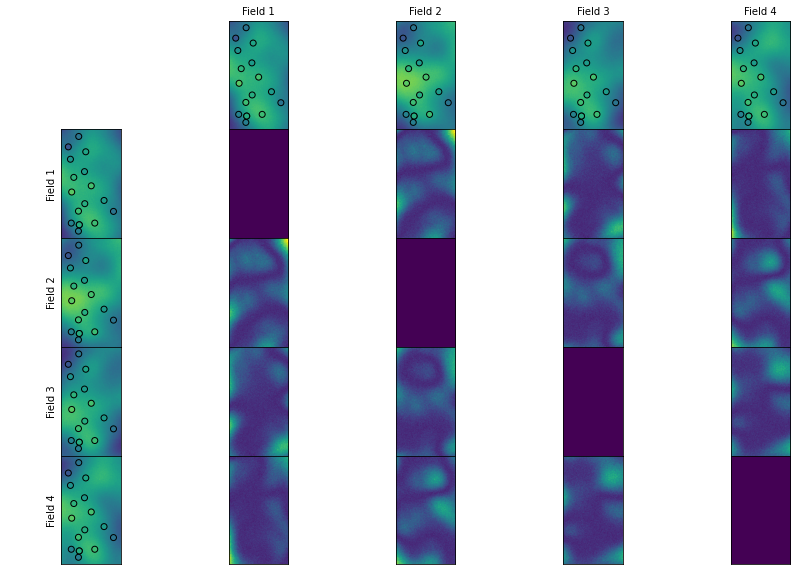

In [39]:
fig, ax = plt.subplots(ens_no + 1, ens_no + 1, figsize=(15, 10))
# plotting kwargs for scatter and image
sc_kwargs = dict(c=temp_cond_val, edgecolors="k", vmin=np.min(field), vmax=np.max(field))

#extent : floats (left, right, bottom, top), optional extent=2 * [0, 5], 
im_kwargs = dict(extent=[-0.5, np.shape(field)[1]-0.5,0,np.shape(field)[2]], origin="lower", vmin=np.min(field), vmax=np.max(field))
im_kwargs2 = dict(extent=[-0.5, np.shape(field)[1]-0.5,0,np.shape(field)[2]], origin="lower", vmin=0, vmax=2)

for i in range(ens_no):
      # conditioned fields and conditions
    ax[i + 1, 0].imshow(field[i].T , **im_kwargs)
    ax[i + 1, 0].scatter(condgrid_x,condgrid_y, **sc_kwargs)
    ax[i + 1, 0].set_ylabel(f"Field {i+1}", fontsize=10)
    ax[0, i + 1].imshow(field[i].T, **im_kwargs)
    ax[0, i + 1].scatter(condgrid_x,condgrid_y, **sc_kwargs)
    ax[0, i + 1].set_title(f"Field {i+1}", fontsize=10)
    # absolute differences
    for j in range(ens_no):
        ax[i + 1, j + 1].imshow(np.abs(field[i] - field[j]).T, **im_kwargs2)

# beautify plots
ax[0, 0].axis("off")
for a in ax.flatten():
    a.set_xticklabels([]), a.set_yticklabels([])
    a.set_xticks([]), a.set_yticks([])
    
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()

Closer look

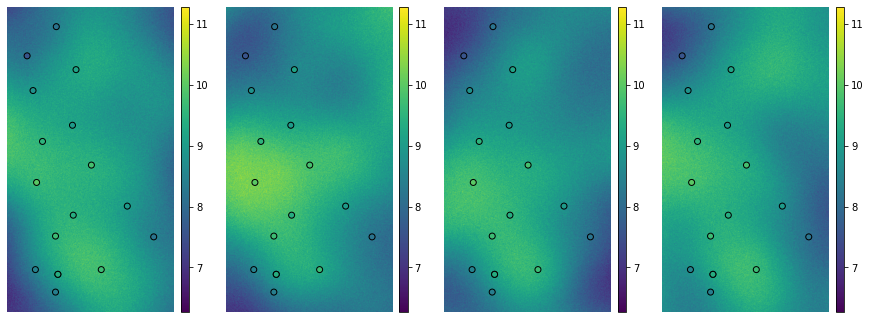

In [40]:
fig, axes = plt.subplots(ncols=4, figsize=(15,10))
axes = axes.flatten()

for i in range(ens_no):
    phandle = axes[i].imshow(field[i].T,**im_kwargs)
    axes[i].scatter(condgrid_x,condgrid_y, c=temp_cond_val, edgecolors="k", vmin=np.min(field), vmax=np.max(field))
    axes[i].axis('equal')
    axes[i].set_axis_off()
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = plt.colorbar(phandle,cax=cax)

# 3D Kriging for demonstration purposes

This data is actually from 2m probes (hence so low), but let's add some fake z data so you can see 3D Kriging and visualization with PyVista.

Here's an example of a function:

In [41]:
import scipy.stats

Generate some random numbers, from a distribution that has a mean of 100, standard deviation of 30. We want as many fake z's as there are x's in our data (`len(temp_df.x)`)

In [42]:
fake_z = scipy.stats.norm.rvs(100, 10, size=len(temp_df.x_easting)) 
fake_z

array([ 95.60126408, 100.04361984,  91.215677  , 113.79590204,
       107.75741849, 108.20232038, 106.30911164, 101.7654885 ,
        88.61740942, 105.5810137 ,  88.52468265, 102.3423703 ,
        81.89648622,  96.8635131 , 107.66176063,  99.78224345,
       101.16888456])

In [43]:
temp_df.z = fake_z

Make a new grid so that it's not too big...

In [44]:
dx=200
dy=200
dz=10
gridx = np.arange(np.min(temp_df.x_easting), np.max(temp_df.x_easting),dx); print(np.shape(gridx))
gridy = np.arange(np.min(temp_df.y_northing), np.max(temp_df.y_northing),dy); print(np.shape(gridy))
gridz = np.arange(np.min(temp_df.z), np.max(temp_df.z),dz); print(np.shape(gridz))


(17,)
(34,)
(4,)


Re-fit variogram in 3d.

In [45]:
temp_cond_pos_3d = [[temp_df.x_easting], [temp_df.y_northing], [temp_df.z]]

In [46]:
bin_center_3d, dir_vario_3d, counts_3d = gs.vario_estimate(
*((temp_cond_pos_3d), temp_cond_val),
direction=gs.rotated_main_axes(dim=3, angles=1.57),
#angles_tol=np.pi / 8,
#bandwidth=8,
return_counts=True,
)

In [47]:
vario_model_3d = gs.Gaussian(dim=3, len_scale=[2300, 1600], angles=1.57) 
print("Original:")
print(vario_model_3d)
vario_model_3d.fit_variogram(bin_center_3d, dir_vario_3d) #, nugget=True)

Original:
Gaussian(dim=3, var=1.0, len_scale=2.3e+03, nugget=0.0, anis=[0.696, 0.696], angles=[1.57, 0.0, 0.0])


({'anis': array([8.32634502e-01, 3.39069128e+04]),
  'len_scale': 1804.6347694955118,
  'nugget': 0.033636377805475695,
  'var': 0.6077110098904074},
 array([[ 2.00596026e-01,  4.84066317e+02,  3.50788113e-03,
          3.93375423e-02,  1.59640379e+10],
        [ 4.84066317e+02,  1.49413979e+06,  2.95932381e+01,
         -7.11002147e+00,  1.34676099e+14],
        [ 3.50788113e-03,  2.95932381e+01,  4.28747412e-03,
          6.17582689e-04,  1.95119030e+10],
        [ 3.93375423e-02, -7.11002147e+00,  6.17582689e-04,
          9.75115381e-02,  2.81056261e+09],
        [ 1.59640379e+10,  1.34676099e+14,  1.95119030e+10,
          2.81056261e+09,  1.28499267e+24]]))

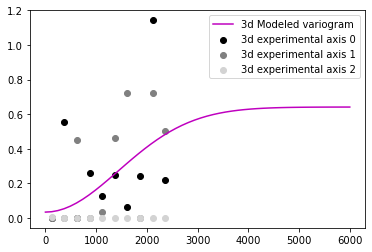

In [ ]:
vario_model_3d.plot(x_max=6000, c='m', label='3d Modeled variogram') #,ax=axes[0],alpha=0.5)
plt.scatter(bin_center_3d, dir_vario_3d[0],c='k', label='3d experimental axis 0') 
plt.scatter(bin_center_3d, dir_vario_3d[1],c='gray', label='3d experimental axis 1') 
plt.scatter(bin_center_3d, dir_vario_3d[2],c='lightgray', label='3d experimental axis 2') 
plt.legend()

In [48]:
pos3 = [temp_df.x_easting.values,temp_df.y_northing.values,temp_df.z] # X Y Z
field3 = temp_df['2mCorr'] # temperature
print(np.shape(pos3),np.shape(field3))
normalizer = gs.normalizer.LogNormal
krige = gs.krige.Ordinary(vario_model_3d, pos3, field3)#, normalizer=normalizer)
krige.structured((gridx, gridy, gridz))
print('size of kriging estimate',krige.field.shape)

(3, 17) (17,)
size of kriging estimate (17, 34, 4)


## Stuff to let PyVista work on colab

In [49]:
if IN_COLAB:
    # setup enviornment for interactive plotting
    !apt-get install -qq xvfb
    !pip install pyvista panel -q

import os
if IN_COLAB:
    os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
    os.environ['DISPLAY'] = ':99'

    import panel as pn
    pn.extension('vtk')


Selecting previously unselected package xvfb.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 1.4 MB 3.2 MB/s 
     |████████████████████████████████| 88.3 MB 97 kB/s 
     |████████████████████████████████| 1.1 MB 42.8 MB/s 
     |████████████████████████████████| 271 kB 70.5 MB/s 
     |████████████████████████████████| 144 kB 55.0 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 


AttributeError: ignored

In [50]:
if IN_COLAB:
    !pip install -q piglet pyvirtualdisplay
    !pip install -q pyvista
    !apt-get -qq install xvfb


     |████████████████████████████████| 67 kB 1.9 MB/s 


In [51]:
if IN_COLAB:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(600, 400))
    display.start()



In [52]:
if IN_COLAB:
    # !pip install pythreejs
    !pip install ipyvtklink

     |████████████████████████████████| 255 kB 3.8 MB/s 


In [53]:
# new cell
import pyvista as pv
# pv.set_jupyter_backend('pythreejs')
pv.set_jupyter_backend('ipyvtklink')

In [54]:
if IN_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

In [ ]:
# from google.colab import output
# output.disable_custom_widget_manager()

In [55]:
# pv.global_theme.background = 'white'
# pv.global_theme.antialiasing = True
pv.set_plot_theme("document")

Just a test of the display (nothing from our data or modeling)

In [56]:
sphere = pv.Sphere()
# short example
sphere.plot(notebook=True, window_size=(600,400))
plt.show()

ViewInteractiveWidget(height=400, layout=Layout(height='auto', width='100%'), width=600)

## Putting the 3d kriging values into PyVista object

In [57]:
# https://docs.pyvista.org/examples/00-load/create-uniform-grid.html
values = krige.field

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (dx, dy, dz)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = values.flatten(order="F")  # Flatten the array!


Now plotting!

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Now plot the grid!
grid.plot(notebook=True, window_size=(600,400),show_edges=False) #show_bounds=True

ViewInteractiveWidget(height=400, layout=Layout(height='auto', width='100%'), width=600)

In [ ]:
# Now plot the grid!
IP = pv.Plotter()
IP.add_mesh(grid,opacity=0.6) #plot(notebook=True, window_size=(600,400),show_edges=False) #show_bounds=True
IP.set_scale(zscale=2)
IP.add_axes()
IP.show()

In [ ]:
plt.imshow(krige.field[:,:,0])

# More resources

If you are familiar with Scikit-Learn
- scikit-gstat: A scipy flavoured geostatistical variogram analysis toolbox
    - `!pip install scikit-gstat`

If you have Microsoft operation system (not a Mac or Linux), you can try 
- [Stanford Geostatistcal Modeling Software- SGEMS](http://sgems.sourceforge.net/)
    - has SGSIM, multiple point geostatistics, indicator kriging/simulation, etc.
- [PyGeostat](http://www.ccgalberta.com/pygeostat/installation.html)
    - calls GSLib functions

GeostatsPy also calls GSLib functions but has work arounds for Mac's.
- [GeostatsPy](https://www.michaelpyrcz.com/my-python-package.html)
    


